<a href="https://colab.research.google.com/github/BehnoodRasti/SparseEDAA/blob/main/SparseEDAA_Alex_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git
#!git clone https://github.com/BehnoodRasti/SUnCNN.git

In [2]:
#!pip install munkres

In [3]:
import time
import os

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import numpy.linalg as LA
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

from munkres import Munkres
#from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
#from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
#from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
#from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SAD 
#from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner
from IPython.display import clear_output
import sys

In [4]:
import scipy.io
import numpy as np
fname2  = "data/DC1/Y_clean.mat"
mat2 = scipy.io.loadmat(fname2)
img_np_gt = mat2["Y_clean"]
img_np_gt = img_np_gt.transpose(2,0,1)
[p1, nr1, nc1] = img_np_gt.shape
img_resh=np.reshape(img_np_gt,(p1,nr1*nc1))
#%%
fname3  = "data/DC1/XT.mat"
mat3 = scipy.io.loadmat(fname3)
A_true_np = mat3["XT"]

#%%
fname4  = "data/DC1/EE.mat"
mat4 = scipy.io.loadmat(fname4)
EE = mat4["EE"]
D=EE
#%%
p = 5 # number of endmembers

In [5]:
img_np_gt.shape

(224, 75, 75)

In [6]:
img_resh.shape

(224, 5625)

In [7]:
img_resh.min()

0.022721152752637863

In [8]:
img_resh.max()

0.9662235379219055

In [9]:
LA.norm(img_resh, axis=0, ord=2, keepdims=True)

array([[11.48092905, 11.48092905, 11.48092905, ..., 11.48092905,
        11.48092905, 11.48092905]])

In [10]:
Y = img_resh

In [11]:
L, N = Y.shape

In [12]:
indices = np.random.choice(np.arange(N), size=100)

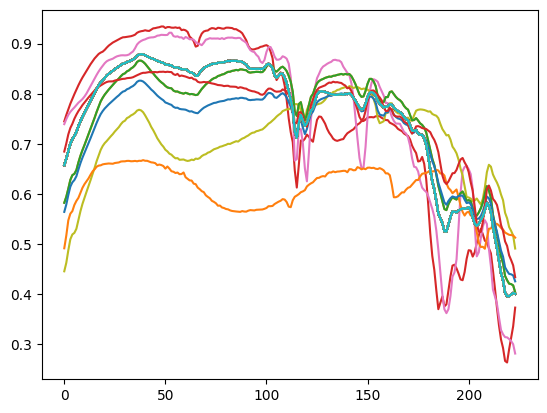

In [13]:
plt.plot(img_resh[:, indices]);

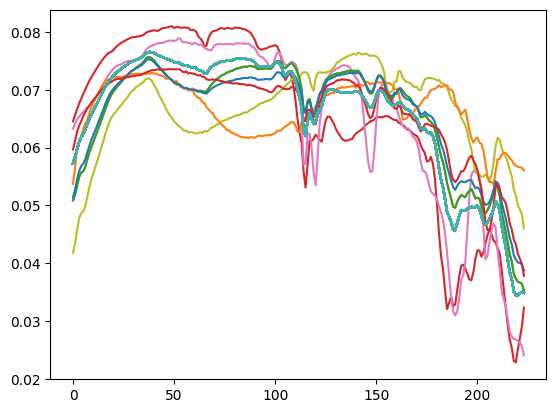

In [14]:
Y = Y / LA.norm(Y, axis=0, ord=2, keepdims=True)
plt.plot(Y[:, indices]);

In [15]:
# !pip install cvxpylayers

In [16]:
# import cvxpy as cp
# import torch
# from cvxpylayers.torch import CvxpyLayer

# p, N = 4, 100
# LibS=220
# x = cp.Variable((p,N))
# AA = cp.Parameter((LibS, p))
# bb = cp.Parameter((LibS,N))
# onesp=torch.ones((p,1))#.to(self.device) 
# onesn=torch.ones((N,1))#.to(self.device) 
# constraints = [onesp.t()@x == onesn.t()]
# objective = cp.Minimize(0.5 * cp.pnorm((AA @ x - bb)**2, p=2))
# problem = cp.Problem(objective, constraints)
# assert problem.is_dpp()

# cvxpylayer = CvxpyLayer(problem, parameters=[AA, bb], variables=[x])
# A_tch = torch.randn(LibS, p, requires_grad=True)
# b_tch = torch.randn(LibS,N, requires_grad=True)

# # solve the problem
# solution, = cvxpylayer(A_tch, b_tch,'ignore_dpp = True')
# print(solution)
# # compute the gradient of the sum of the solution with respect to A, b
# solution.sum().backward()

In [17]:
class SparseEDAA:
    def __init__(self, T=100, K1=5, K2=5, M=50):
        self.T = T
        self.K1 = K1
        self.K2 = K2
        self.M = M

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def solve(
        self,
        Y,
        D,
        p,
        seed=0,
        **kwargs,
    ):
        best_E = None
        best_A = None
        U1, Sig1, U1T = torch.linalg.svd(D.t()@ D, full_matrices=False)
        
        L, N = Y.shape
        LibS=D.shape[1]
        def residual(a, b):
            return 0.5 * ((Y - (D @ b) @ a) ** 2).sum()

        def residual_l1(a, b):
            return (Y - (D @ b) @ a).abs().sum()

        def lossTot(a, b, lamb):
            return .5 * ((Y - D @ a) ** 2).sum()#residual(a, b) + lamb * b.abs().sum()
        
        def loss(a, b):
            return residual(a, b)
        def grad_A(a, b, S2, L2):
            #DB = D @ b
            #ret = -DB.t() @ (Y - DB @ a)
            return -mu2*B.t() @ (S2 - B @ A - L2)
#        def grad_A(a, b):
#            DB = D @ b
#            ret = -DB.t() @ (Y - DB @ a)
#            return ret
        def grad_B(a, b, lamb):
            return -D.t() @ ((Y - D @ b @ a) @ a.t())+lamb*torch.sign(b)

#        def update(a, b,c):
#            return F.softmax(a*torch.exp(-c*b), dim=0)#F.softmax(torch.log(a) + b, dim=0)
#        def update(a, b):
#            return F.softmax(torch.log(a) + b, dim=0)
        def update(a, b,c, nu):
            return a*torch.exp(-c*b)*torch.exp(-c*nu-1)       
        def updateB(a, b):
            return a * b
        
        def computeLA(a, b):
            DB = D @ b
            S = torch.linalg.svdvals(DB)
            return S[0] * S[0]

        max_correl = lambda e: np.max(np.corrcoef(e.T) - np.eye(p))

        results = {}
        eps=sys.float_info.epsilon
        tic = time.time()

        for m in tqdm(range(self.M)):
            torch.manual_seed(m + seed)
            generator = np.random.RandomState(m + seed)

            with torch.no_grad():

                # Matrix initialization
                #B = torch.rand((LibS, p))
                B = F.softmax(0.008*torch.rand((LibS, p)), dim=0)
                # B = F.softmax(torch.rand((LibS, p)), dim=0)
                A = (1 / p) * torch.ones((LibS, N))
                L1 = torch.zeros((LibS,p))
                #B = F.softmax(torch.rand((LibS, LibS)), dim=0)
                #A = (1 / p) * torch.ones((LibS, N))
                #L1 = torch.zeros((LibS,LibS))
                S1=L1
                L2 = torch.zeros((LibS,N))
                S2=L2
                #Sig2=torch.zeros((LibS,LibS))
                Sig2=torch.zeros((p,p))
                U2=Sig2
                U2T=Sig2
                inv2=Sig2
                inv1=torch.zeros((LibS,LibS))
                # Send matrices on GPU
                D = D.to(self.device)
                Y = Y.to(self.device)
                A = A.to(self.device)
                B = B.to(self.device)
                S1 = S1.to(self.device)
                S2 = S2.to(self.device)
                L1 = L1.to(self.device)
                L2 = L2.to(self.device)
                #Sig1 = Sig1.to(self.device)
                U1 = U1.to(self.device)
                U1T = U1T.to(self.device)
                U2 = U2.to(self.device)
                U2T = U2T.to(self.device)
                Sig2 = Sig2.to(self.device)
                inv1 = inv1.to(self.device)
                inv2 = inv2.to(self.device)
                eyep=torch.eye(p).to(self.device) 
                eyeLibS=torch.eye(LibS).to(self.device) 
                onesp=torch.ones((p,1)).to(self.device) 
                onesLibS=torch.ones((LibS,1)).to(self.device) 
                onesn=torch.ones((N,1)).to(self.device) 
                eyeL=torch.eye(L).to(self.device) 
                # Random Step size factor
                factA = 2 ** generator.randint(-3, 4)
                self.lamb =.008
                mu1=1
                mu2=10
                nu=.9
                soft=torch.nn.Softshrink(self.lamb/mu1)
                hard=torch.nn.Hardshrink(self.lamb/mu1)
                #print(f"etaA => {self.etaA}")
                #print(f"etaB => {self.etaB}")
                DtD=D.t()@D+mu1*eyeLibS
                DtY=D.t()@Y
                inv1=torch.inverse(DtD)#+eyeLibS*eps)
                inv2=-1/(onesLibS.t()@inv1@onesLibS)
                for ii in range(self.T):
                    for kk in range(self.K1):
                        A=(inv1+inv1@onesLibS@inv2@onesLibS.t()@inv1)@(DtY+mu1*(S2-L2))-inv1@onesLibS@(inv2*onesn.t())
                        S2= (A+L2)
                        S2[S2<=0]=0
                        #S1[S1>=1]=1
                        L2 = L2 + A - S2
                        print(lossTot(A,B,self.lamb).item())
                    if ii % 1000 == 0:
                           clear_output(wait=False)
                #fit_m = residual_l1(A, B).item()
                #E = (D @ B).cpu().numpy()
                A = A.cpu().numpy()
                #Xmap = B.t().cpu().numpy()
                #Rm = max_correl(E)
                # Store results
                results[m] = {
                    #"Rm": Rm,
                    #"Em": E,
                    "Am": A,
                    #"Bm": Xmap,
                    #"fit_m": fit_m,
                    #"factA": factA,
                }
        toc = time.time()
        elapsed_time = round(toc - tic, 2)
        print(f"{self} took {elapsed_time}s")

        return A

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

In [18]:
import numpy as np


class AdditiveWhiteGaussianNoise:
    def __init__(self):
        self.sigmas = None
        self.SNR = None
        self.L = None
        self.N = None

    def fit(self, Y, SNR: float):
        """
        Compute sigmas at the desired SNR given a flattened input HSI Y
        """
        assert len(Y.shape) == 2
        self.L, self.N = Y.shape
        #logger.debug(f"Y shape: {Y.shape}")
        self.SNR = SNR
        #logger.debug(f"Desired SNR: {self.SNR}")

        if SNR is None:
            self.sigmas = np.zeros(self.L)
        else:
            assert SNR > 0, "SNR must be stricly positive"
            # Uniform across bands
            sigmas = np.ones(self.L)
            # Normalization
            sigmas /= np.linalg.norm(sigmas)
            #logger.debug(f"Sigmas after normalization: {sigmas[0]}")
            # compute mean sigma
            num = np.sum(Y ** 2) / self.N
            denom = 10 ** (self.SNR / 10)
            sigmas_mean = np.sqrt(num / denom)
            #logger.debug(f"Sigma mean based on SNR: {sigmas_mean}")
            # Noise variance
            sigmas *= sigmas_mean
            #logger.debug(f"Final sigmas value: {sigmas[0]}")
            self.sigmas = sigmas

    def transform(self, Y, seed=0):
        """
        Add White Gaussian Noise to the flattened input HSI Y
        """
        assert self.sigmas is not None, "Must be fitted first"
        assert (self.L, self.N) == Y.shape
        # Fix random seed
        generator = np.random.RandomState(seed=seed)
        # Noise generation
        N = np.diag(self.sigmas) @ generator.randn(self.L, self.N)
        # Additive Noise
        return Y + N

    def fit_transform(self, Y, SNR, seed=0):
        """
        Combine `fit` and `transform` methods.
        See above for their respective usage.
        """
        self.fit(Y, SNR)
        return self.transform(Y, seed=seed)

In [19]:
# # Subspace Setup
# from scipy import linalg
# model = SparseEDAA(K1=1, K2=1, T=10000, M=1)
# #Y = img_resh
# D=EE
# #img_mean=np.mean(img_resh,1).reshape(p1,1)
# #img_mean_rmv=img_resh-img_mean
# #V, SS, U = scipy.linalg.svd(img_mean_rmv@img_mean_rmv.transpose(1,0)/(nr1*nc1), full_matrices=False)
# #Y=V[:,:p].transpose(1,0)@img_mean_rmv
# Y = noise.fit_transform(img_resh, SNR=40, seed=0)
# V, SS, U = scipy.linalg.svd(Y, full_matrices=False)
# Y_r=V[:,:p].transpose(1,0)@Y
# DD = V[:,:p].transpose(1,0)@D
# noise = AdditiveWhiteGaussianNoise()
# Y_r = torch.Tensor(Y_r)
# DD = torch.Tensor(DD)
# D = torch.Tensor(D)
# #Y_DN = torch.Tensor(Y_DN)
# A0 = model.solve(Y_r, DD, p, seed=1)

In [42]:
# Instantiate objects
model = SparseEDAA(K1=1, K2=1, T=10000, M=1)
Y = img_resh
D = EE#np.concatenate((EE, Y), axis=1)
# Call data to return HSI (numpy format)
#Y, _, _ = hsi()

# l2-normalize the data
#Y = Y / LA.norm(Y, axis=0, ord=2, keepdims=True)

noise = AdditiveWhiteGaussianNoise()

Y = noise.fit_transform(Y, SNR=20, seed=0)

from scipy import linalg
V, SS, U = scipy.linalg.svd(Y, full_matrices=False)
PC=np.diag(SS)@U
Y_DN=V[:,:p]@PC[:p,:]
#D = D / LA.norm(D, axis=0, ord=2, keepdims=True)
#D=Y
# Convert the data to tensors
Y = torch.Tensor(Y_DN)
D = torch.Tensor(D)
# Abundances estimation
A0 = model.solve(Y, D, p, seed=1)

# Plot results
#hsi.plot_endmembers(E0=E0)
#hsi.plot_abundances(A0=A0)

27.7134952545166
27.714088439941406
27.713476181030273
27.714218139648438
27.7139892578125
27.71434783935547
27.714820861816406
27.713558197021484
27.712770462036133
27.71259117126465
27.712862014770508
27.713510513305664
27.713146209716797
27.712543487548828
27.71334457397461
27.712631225585938
27.71255874633789
27.713403701782227
27.714069366455078
27.71456527709961
27.714929580688477
27.71460723876953
27.71413230895996
27.713855743408203
27.71430778503418
27.714340209960938
27.714513778686523
27.71382713317871
27.71346664428711
27.71381378173828
27.71255111694336
27.713069915771484
27.713294982910156
27.713382720947266
27.71302604675293
27.714698791503906
27.714153289794922
27.713619232177734
27.71377944946289
27.714384078979492
27.714069366455078
27.71430778503418
27.7142276763916
27.714866638183594
27.71465301513672
27.714191436767578
27.713191986083984
27.713401794433594
27.71437644958496
27.71497344970703
27.71460723876953
27.713970184326172
27.713951110839844
27.71384048461914


In [43]:
D = torch.Tensor(D)
Y = img_resh

In [44]:
img_mean=np.mean(img_resh,1).reshape(p1,1)
img_mean_rmv=img_resh-img_mean
V, SS, U = scipy.linalg.svd(img_mean_rmv@img_mean_rmv.transpose(1,0)/(nr1*nc1), full_matrices=False)
Y=V[:,:p]@V[:,:p].transpose(1,0)@img_mean_rmv
Y.shape

(224, 5625)

In [45]:
(D.t() @ Y ).shape

torch.Size([240, 5625])

In [37]:
plt.plot(D@E0)

NameError: name 'E0' is not defined

In [46]:
import numpy as np
from munkres import Munkres

class BaseAbundancesAligner2:
    def __init__(self, A, criterion):
        self.Aref = A
        self.criterion = criterion
        self.P = None
        self.dists = None

    def fit(self, A):
        raise NotImplementedError

    def transform(self, A):
        assert self.P is not None, "Must be fitted first"
        assert A.shape[0] == self.P.shape[0]
        assert A.shape[0] == self.P.shape[1]

        return self.P @ A

    def transform_endmembers(self, E):
        assert self.P is not None, "Must be fitted first"
        assert E.shape[1] == self.P.shape[0]
        assert E.shape[1] == self.P.shape[1]

        return E @ self.P.T

    def fit_transform(self, A):

        self.fit(A)
        res = self.transform(A)
        return res

    def __repr__(self):
        msg = f"{self.__class__.__name__}_crit{self.criterion}"
        return msg


class MunkresAbundancesAligner2(BaseAbundancesAligner2):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, A):

        # Computing distance matrix
        self.dists = self.criterion(A.T, self.Aref.T)

        # Initialization
        p = A.shape[0]
        P = np.zeros((p, p))

        m = Munkres()
        indices = m.compute(self.dists)
        for row, col in indices:
            P[row, col] = 1.0

        self.P = P.T

In [47]:
# Select a criterion to perform alignment
#criterion = MSE()

# Select an aligner to perform alignment
A_true = A_true_np.reshape((EE.shape[1],nr1*nc1))#[1:p+1,:]
#aligner = MunkresAbundancesAligner2(A=A_true, criterion=criterion)

#A1 = aligner.fit_transform(A0)
#E1 = aligner.transform_endmembers(E0)

#
x = A0.astype(np.float32).reshape((EE.shape[1],nr1*nc1))
SRE = 20*np.log10(LA.norm(A_true,'fro')/LA.norm((A_true - np.clip(x, 0, 1)),'fro'))

print ('SRE: %f' % (SRE))




SRE: 9.639181


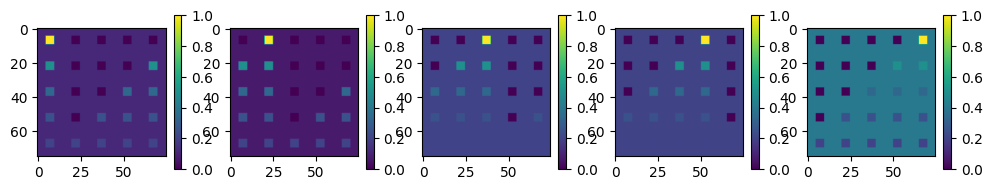

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=p, figsize=(12, 4))
A_reshape = A_true[1:p+1,:].reshape((p, nr1, nc1))
for kk in range(p):
    curr_ax = ax[kk]
    mappable = curr_ax.imshow(A_reshape[kk], vmin=0.0, vmax=1.0)
    fig.colorbar(mappable, ax=curr_ax, shrink=0.5)

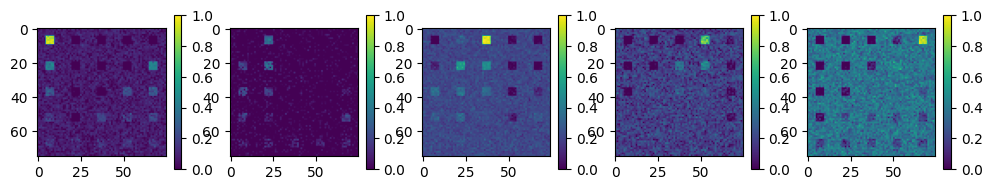

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=p, figsize=(12, 4))
A2 = A0[1:p+1,:].reshape((p, nr1, nc1))
for kk in range(p):
    curr_ax = ax[kk]
    mappable = curr_ax.imshow(A2[kk], vmin=0.0, vmax=1.0)
    fig.colorbar(mappable, ax=curr_ax, shrink=0.5)